# Задача 1. Оценить необходимый размер групп
  
Допустим, мы хотим провести эксперимент, в который попадают клиенты, совершившие покупку во время эксперимента.

- Метрика — средняя выручка с пользователя за время эксперимента;
- Продолжительность — одна неделя;
- Уровень значимости — 0.05;
- Допустимая вероятность ошибки II рода — 0.1;
- Ожидаемый эффект — 20 рублей.

Оцените необходимый размер групп по данным о покупках за неделю с 21 по 28 февраля. Обратим внимание, что в выборку попадают события из полуинтервала [datetime(2022, 2, 21), datetime(2022, 2, 28)).

Для решения используйте данные из файла 2022-04-01T12_df_sales.csv.

В качестве ответа введите необходимый размер групп, округлённый до целого числа десятков round(x, -1).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, ttest_ind
from datetime import datetime
import os

import ipywidgets as widgets

In [2]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

In [4]:
df_sales = read_database('2022-04-01T12_df_sales.csv')

df_sales['date'] = pd.to_datetime(df_sales['date'])

In [24]:
df_metrics = (
        df_sales
        [(df_sales['date'] >= datetime(2022,2,21)) & (df_sales['date'] < datetime(2022,2,28))]
        .groupby('user_id')[['price']].sum()
        .reset_index()
)

In [28]:
std = df_metrics['price'].std()

In [21]:
def get_sample_size_abs(epsilon, std, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

def get_sample_size_arb(mu, std, eff=1.01, alpha=0.05, beta=0.2):
    epsilon = (eff - 1) * mu

    return get_sample_size_abs(epsilon, std=std, alpha=alpha, beta=beta)

def check_ttest(a, b, alpha=0.05):
    """Тест Стьюдента. Возвращает 1, если отличия значимы."""
    _, pvalue = ttest_ind(a, b)
    return int(pvalue < alpha)

In [31]:
epsilon = 20
alpha = 0.05
beta = 0.1


sample_size = get_sample_size_abs(epsilon, std, alpha, beta)
print(f'sample_size = {round(sample_size, -1)}\n')

sample_size = 34570



# Задача 2. MDE
  

В прошлом задании получилось, что необходимый размер групп больше имеющихся данных за одну неделю. Какой минимальный эффект мы можем отловить с теми же вероятностями ошибок на данных
с 21 по 28 февраля?

Ответ округлите до целого значения.

In [32]:
def get_minimal_determinable_effect(std, sample_size, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    disp_sum_sqrt = (2 * (std ** 2)) ** 0.5
    mde = (t_alpha + t_beta) * disp_sum_sqrt / np.sqrt(sample_size)
    return mde

In [40]:
sample_size = len(df_metrics)/2
alpha = 0.05
beta = 0.1

mde = get_minimal_determinable_effect(
    std, sample_size, alpha=alpha, beta=beta
)
print(round(mde, 0))

33.0


# Задача 3. Реализация метода оценки размера выборки
  

Реализуйте функцию для оценки размера групп.
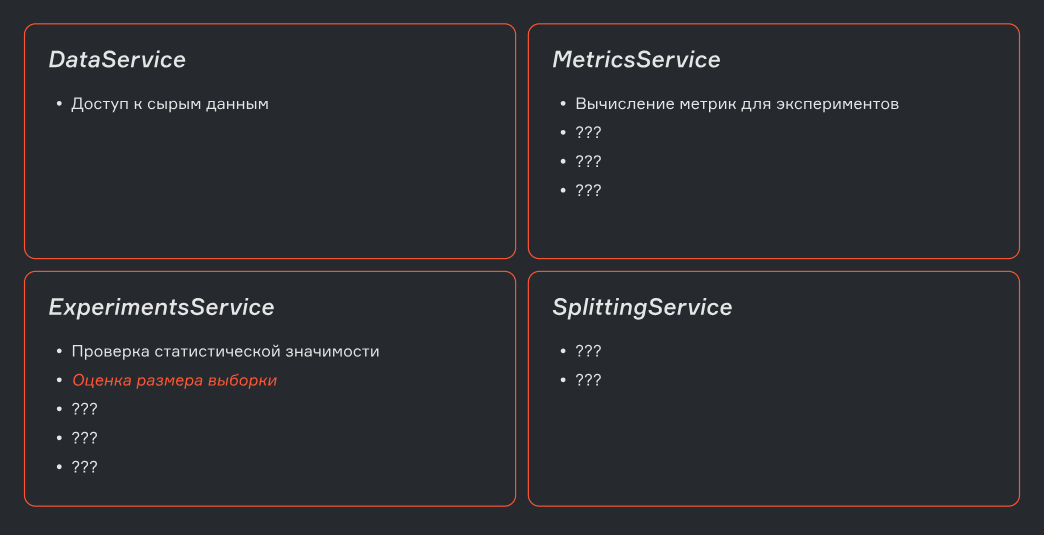

Напишите метод estimate_sample_size класса ExperimentsService. Описание метода есть в шаблоне решения ниже.

Обратите внимание:
- Размер эффекта задаётся в процентах;
- Для вычисления стандартного отклонения используйте функцию np.std с параметрами по умолчанию.
- Не используйте агрегацию внутри функции.
- Стандартное отклонение и значение среднего необходимо посчитать по полученному столбцу с метрикой.
- Скопируйте код шаблона в py-файл, допишите недостающие части, сохраните изменения и отправьте файл в проверяющую систему.

Для самопроверки внизу шаблона есть пример теста решения. При проверке решения будут использоваться другие тестовые данные.

In [42]:
import numpy as np
import pandas as pd
from pydantic import BaseModel
from scipy import stats


class Design(BaseModel):
    """Дата-класс с описание параметров эксперимента.
    
    statistical_test - тип статтеста. ['ttest']
    effect - размер эффекта в процентах
    alpha - уровень значимости
    beta - допустимая вероятность ошибки II рода
    """
    statistical_test: str
    effect: float
    alpha: float
    beta: float


class ExperimentsService:

    def estimate_sample_size(self, metrics, design):
        """Оцениваем необходимый размер выборки для проверки гипотезы о равенстве средних.
        
        Для метрик, у которых для одного пользователя одно значение просто вычислите размер групп по формуле.
        Для метрик, у которых для одного пользователя несколько значений (например, response_time),
            вычислите необходимый объём данных и разделите его на среднее количество значений на одного пользователя.
            Пример, если в таблице metrics 1000 наблюдений и 100 уникальных пользователей, и для эксперимента нужно
            302 наблюдения, то размер групп будет 31, тк в среднем на одного пользователя 10 наблюдений, то получится
            порядка 310 наблюдений в группе.

        :param metrics (pd.DataFrame): датафрейм со значениями метрик из MetricsService.
            columns=['user_id', 'metric']
        :param design (Design): объект с данными, описывающий параметры эксперимента
        :return (int): минимально необходимый размер групп (количество пользователей)
        """
        
        effect = design.effect
        alpha = design.alpha
        beta = design.beta
        
        std = np.std(metrics['metric'].values)
        mean = np.mean(metrics['metric'].values)
        
        epsilon = effect / 100 * mean
        coef = metrics['user_id'].nunique() / len(metrics)
        
        t_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
        t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
        z_scores_sum_squared = (t_alpha + t_beta) ** 2
        
        sample_size = int(
            np.ceil(
                z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2) * coef
            )
        )
        
        return sample_size


if __name__ == '__main__':
    metrics = pd.DataFrame({
        'user_id': [str(i) for i in range(10)],
        'metric': [i for i in range(10)]
    })
    design = Design(
        statistical_test='ttest',
        alpha=0.05,
        beta=0.1,
        effect=3.
    )
    ideal_sample_size = 9513

    experiments_service = ExperimentsService()
    sample_size = experiments_service.estimate_sample_size(metrics, design)
    assert sample_size == ideal_sample_size, 'Неверно'
    print('simple test passed')

simple test passed
